### Yelp Dataset User,Bussiness Similarities Using UCF,ICF,SVD

For better understanting of the project check the readme file. Instead of pandas dataframe i used dictionaries, because by then i was not familiar with pandas.

In [1]:
import numpy as np
import seaborn as sns
import matplotlib as plt
import json
import pandas as pd
from pandas import DataFrame
import csv
import ijson


**Step 1**

First we pass the pruned data in a data frame and reverse it with the df_pivot command. We do this to keep users as rows and businesses as columns. This is how we create the sparse matrix, the values that did not exist as ratings are now passed as zeros. Then we print the non-zeros elements of the table after we have made it csr sparse.


In [2]:
from scipy.sparse import csr_matrix
from scipy import sparse

df = pd.read_csv('pruned_data.csv',encoding='utf-8',dtype=None, names=['user_id', 'business_id', 'rating'],delimiter = ',')

df = df.pivot_table(index='user_id', columns='business_id', values='rating',fill_value=0)
mat = df.values


print(mat)
A = np.squeeze(np.asarray(mat))
print(A.shape)
R = sparse.csr_matrix(A)
print(R)
print(R.size)

[[0 0 0 ... 0 0 0]
 [0 3 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(4794, 4092)
  (0, 45)	1
  (0, 155)	5
  (0, 326)	3
  (0, 360)	4
  (0, 401)	4
  (0, 460)	4
  (0, 463)	5
  (0, 789)	4
  (0, 906)	4
  (0, 944)	4
  (0, 1093)	3
  (0, 1118)	4
  (0, 1131)	4
  (0, 1244)	3
  (0, 1251)	3
  (0, 1525)	4
  (0, 1560)	4
  (0, 1738)	3
  (0, 1797)	4
  (0, 2057)	4
  (0, 2231)	5
  (0, 2364)	2
  (0, 2383)	5
  (0, 2665)	4
  (0, 2807)	4
  :	:
  (4792, 3980)	5
  (4792, 4015)	2
  (4793, 367)	5
  (4793, 395)	5
  (4793, 646)	3
  (4793, 705)	5
  (4793, 870)	4
  (4793, 1077)	5
  (4793, 1082)	4
  (4793, 1754)	5
  (4793, 2119)	5
  (4793, 2190)	3
  (4793, 2322)	5
  (4793, 2523)	5
  (4793, 2574)	5
  (4793, 2595)	4
  (4793, 2830)	4
  (4793, 3168)	2
  (4793, 3267)	5
  (4793, 3280)	4
  (4793, 3315)	5
  (4793, 3642)	4
  (4793, 3807)	5
  (4793, 4018)	4
  (4793, 4041)	4
197112



Below we randomly remove 5% of the array and save it as samples.

In [3]:
import random

#stores the 5%
samples = []

#nonzero indexes
indexes = []
for i, j in zip(*A.nonzero()):
    indexes.append([i,j])

total_non_zeros = np.count_nonzero(A)

#The length after we remove the 5%
newLen = total_non_zeros- (int(0.05*total_non_zeros))



while(total_non_zeros > newLen):
    random_index = random.choice(indexes)
    indexes.remove(random_index) #removes the random index from the non zero indexes
    
    samples.append([random_index[0],random_index[1],A[random_index[0],random_index[1]]]) #store it as a sample
    A[random_index[0],random_index[1]] = 0 #replace the removed index in the sparse matrix by replacing it with 0
    
    total_non_zeros = np.count_nonzero(A) #the new length from the sparce matrix
    


R = sparse.csr_matrix(A)



print("The new length of the sparse matrix",R.size)
print("The 5% sample",len(samples))


The new length of the sparse matrix 187257
The 5% sample 9855


**Step 2**

In this step we implement the UCF algorithm. First I find the pairwise cosine similarity, which will be a square size array (4794, 4794).

In [4]:
from sklearn.metrics.pairwise import cosine_similarity

similarities = cosine_similarity(R,dense_output=False)
print('pairwise sparse output:\n {}\n'.format(similarities))
print(similarities.shape)
print(similarities.size)


pairwise sparse output:
   (0, 4489)	0.03540444145243883
  (0, 4373)	0.012938049570212948
  (0, 3971)	0.019063065415921013
  (0, 3760)	0.031364048958611966
  (0, 3445)	0.015132276226637412
  (0, 3375)	0.05348645244402103
  (0, 2241)	0.018418420079396598
  (0, 2203)	0.03374716423683692
  (0, 2191)	0.04237354706163688
  (0, 2085)	0.030793230903513432
  (0, 2038)	0.01822555172712694
  (0, 1752)	0.021266754085256787
  (0, 1253)	0.04991272901962332
  (0, 1157)	0.010774901836461584
  (0, 937)	0.01518080315898054
  (0, 659)	0.027831938065914576
  (0, 588)	0.014863907018912369
  (0, 3464)	0.016208051498450275
  (0, 3174)	0.007943782184494598
  (0, 1947)	0.01976031602432117
  (0, 990)	0.007464346312286637
  (0, 905)	0.02407005530465018
  (0, 8)	0.006241123073811121
  (0, 4739)	0.013894609129295448
  (0, 4720)	0.052808586884294316
  :	:
  (4793, 695)	0.04492063148919793
  (4793, 694)	0.06688850983855814
  (4793, 630)	0.04950980415950502
  (4793, 626)	0.07051317386542942
  (4793, 554)	0.028073696

Αφού έχω βρει τα similarities θα βρω τους k  χρήστες που έχουν κάνει rate στην ίδια επιχείρηση με το κάθε sample μου. Αυτό υλοποιείτε με την συνάρτηση totalBorURating(),το flag που υπάρχει σαν παράμετρο είναι για να ξεχωρίζει αν χρειάζεται να βγάλω τους k users ή businesses(για τον ICF).H παρακάτω συνάρτηση (similaritiesOfBorU()) βρίσκει τα similarities από τους k users ή businesses. Η παράμετρο businessOrUsersRates είναι το λεξικό που υλοποιήθηκε απο την προηγουμένη συνάρτηση, ώστε να μπορεί να βρει τα indexes των k users με την εκάστοτε business και έπειτα να ψάξει στον πίνακα similarities και να πάρει το κατάλληλο.

Once I have found the similarities I will find the k users who have rate in the same business with each of my samples. I implement this with the totalBorURating () function, the flag that exists as a parameter is to distinguish if I need to remove k users or businesses (for ICF). The following function (similaritiesOfBorU ()) finds the similarities from k users or businesses. The businessOrUsersRates parameter is the dictionary implemented by the previous function, so that it can find the indexes of k users with the respective business and then search the similarities table and get the appropriate one.

In [5]:
def totalBorURating(sparseMatrix,samples,flag):
    
    totalUsersOrBusiness = {}

    for rating in samples:
        
        businessSample= rating[1]
        userSample= rating[0]
        
        if flag==1:
            tempB = sparseMatrix[:,businessSample] #
            users = np.transpose(np.nonzero(tempB))

            #For the users
            totalUsersOrBusiness[userSample,businessSample] = users[:,0]
        else: #(ICF)

            tempB = sparseMatrix[:,userSample]
            business = np.transpose(np.nonzero(tempB))
            
            #For the bussiness
            totalUsersOrBusiness[userSample,businessSample] = business[:,0]

        
    return totalUsersOrBusiness

def similaritiesOfBorU(businessOrUsersRates,similarities,flag):
    
    simiOfBorU = {}
    for key in businessOrUsersRates:
        
        simiList = []

        user = key[0]
        business = key[1]


        for item in businessOrUsersRates[key]:
            
            
            if flag == 1:
                userSimilarToCurrent = similarities[user,item]
                simiList.append(userSimilarToCurrent)
        
            
            else: #(ICF)
                businessSimilarTocurrent = similarities[business,item]
                simiList.append(businessSimilarTocurrent)
        
        
        simiOfBorU[user,business] = simiList
        
        
    return simiOfBorU


**Example**

Here is an example of the structures we implemented. Where the key from each dictionary is the sample and the value in the first dictionary is a vector with k users (where we have passed their indexes) and in the second are the similarities from them.

In [6]:

usersThatRatedB = totalBorURating(R,samples,1)
simiOfUsersThatRatedB = similaritiesOfBorU(usersThatRatedB,similarities,1)

for key in usersThatRatedB:
    print(key,usersThatRatedB[key])
    break
for key in simiOfUsersThatRatedB:
    print(key,simiOfUsersThatRatedB[key])
    break

(419, 3687) [ 126  249  387  626  817  882 1118 1258 1280 1560 1570 1654 1670 1714
 1763 1783 1847 1906 2050 2369 2409 2481 2686 2833 2835 2852 2960 2996
 3005 3082 3192 3210 3342 3550 3664 3667 3675 3764 3849 3855 3981 4465
 4549 4735]
(419, 3687) [0.0, 0.040385930338458664, 0.015492816984745451, 0.0, 0.0, 0.05211840743189904, 0.023925810429144524, 0.08489859454178378, 0.037646914028931784, 0.0, 0.0, 0.019533075648188077, 0.021789259115386973, 0.023041612276175027, 0.0, 0.009810203934186523, 0.033484892205107614, 0.028944819367632352, 0.07147153193322318, 0.04766161515547998, 0.001841258466233778, 0.0, 0.0, 0.04479663213660939, 0.0, 0.037080703045064556, 0.0, 0.048517907962830994, 0.013809122125695284, 0.0, 0.04799075077683858, 0.02859286301754114, 0.015992734551754654, 0.051311298258613865, 0.01704317134479091, 0.033689903761184956, 0.03386975355326836, 0.018228642573118157, 0.016194334692395007, 0.02924336844734412, 0.04001376898938355, 0.0122110956707199, 0.08109716493543526, 0.008

Then after we have made our structures we sort them. I also find the ratings from the users in each business.

In [7]:
def sortArraysWithIndexes(arr, length): 
    sorted_indexes = np.argsort(arr)[-length:]
    sorted_arr = [arr[i] for i in sorted_indexes]
    sorted_indexes = list(reversed(sorted_indexes))
    sorted_arr = list(reversed(sorted_arr))
    return sorted_indexes, sorted_arr


def sortByCosineSimi(usersOrBusiness,simiOfUsersOrBusiness):
    for key in usersOrBusiness:
        length = len(simiOfUsersOrBusiness[key])
        sorted_indexes,sorted_arr = sortArraysWithIndexes(simiOfUsersOrBusiness[key],length)
        simiOfUsersOrBusiness[key] = sorted_arr
        temp = []
        arr2 = usersOrBusiness[key]
        for index in sorted_indexes:
            sortedvalue = arr2[index]
            temp.append(sortedvalue)
            usersOrBusiness[key] = temp
    return usersOrBusiness,simiOfUsersOrBusiness

sortedUsersThatRatedB,sortedSimiOfUsersThatRatedB = sortByCosineSimi(usersThatRatedB,simiOfUsersThatRatedB)

def userRatings(sortedBusinessOrUsers,matrix,flag):
    ratings = {}
    for key in sortedBusinessOrUsers:

        ratingsList = []

        user = key[0]
        business = key[1]

        for item in sortedBusinessOrUsers[key]:
            
            #flag 1 is for ucf, flag != 1  icf
            if flag==1:
                rating = matrix[item,business]
                ratingsList.append(rating)
            else:
                rating = matrix[item,user]
                ratingsList.append(rating)

        ratings[user,business] = ratingsList


            
    return ratings

ratingsForB = userRatings(usersThatRatedB,R,1)

**Example**

-Key : sample1 , Value : vector of ratings

-Key : sample1 , Value : vector of k users

-Key : sample1 , Value : vector of similarity of k users



In [8]:
for key in ratingsForB:
    print(key,ratingsForB[key])
    break
for key in sortedUsersThatRatedB:
    print(key,sortedUsersThatRatedB[key])
    break
for key in sortedSimiOfUsersThatRatedB:
    print(key,sortedSimiOfUsersThatRatedB[key])
    break


(419, 3687) [4, 3, 5, 4, 4, 5, 4, 4, 4, 3, 4, 3, 4, 2, 4, 4, 4, 3, 4, 4, 5, 4, 5, 4, 5, 5, 3, 4, 1, 4, 4, 4, 3, 4, 3, 4, 3, 5, 4, 4, 5, 4, 4, 4]
(419, 3687) [1258, 4549, 2050, 882, 3550, 2996, 3192, 2369, 2833, 249, 3981, 1280, 2852, 3675, 3667, 1847, 3855, 1906, 3210, 1118, 1714, 1670, 1654, 3764, 3664, 3849, 3342, 387, 3005, 4465, 1783, 4735, 2409, 817, 626, 2481, 1560, 1570, 1763, 2686, 2835, 2960, 3082, 126]
(419, 3687) [0.08489859454178378, 0.08109716493543526, 0.07147153193322318, 0.05211840743189904, 0.051311298258613865, 0.048517907962830994, 0.04799075077683858, 0.04766161515547998, 0.04479663213660939, 0.040385930338458664, 0.04001376898938355, 0.037646914028931784, 0.037080703045064556, 0.03386975355326836, 0.033689903761184956, 0.033484892205107614, 0.02924336844734412, 0.028944819367632352, 0.02859286301754114, 0.023925810429144524, 0.023041612276175027, 0.021789259115386973, 0.019533075648188077, 0.018228642573118157, 0.01704317134479091, 0.016194334692395007, 0.015992734

For the calculation of UCF and ICF we have implemented a function, as the operations performed on both algorithms are the same, with the only difference being that the parameters are passed.

In [15]:
def calculateUCFOrICF(k,vectorOfUorB,vectorSimilarity,ratings):
    score = np.zeros(len(vectorOfUorB))
    counter = 0
    for key in vectorOfUorB:
        
        t = 0
        arithmetic = 0
        denominator = 0
        

        tempSimilarity = vectorSimilarity[key][0:k]
        tempRatings = ratings[key][0:k]

        denominator = np.sum(tempSimilarity)               
        arithmetic = np.dot(tempSimilarity,tempRatings)

        if denominator == 0:
            score[counter] = 0
        else:
            score[counter] = round(arithmetic/denominator)
        counter = counter + 1
    return score



**Step 3**

Here we implement the ICF algorithm. As can be seen the difference with ucf is in the structures we have implemented. In ICF we have k similar businesses in contrast to the ucf where we have k similar users. So we reverse the R table so that we have business  rows instead of users. Then we calculate the cosine similarity in the same way as before but with the inverse R. We notice that now it is again a square table but with size (4092, 4092), the same size as our business. Then we implement the same structures as before but with k similar companies (so we call the same functions but with a different flag).

In [10]:
reverseR = R.T

similaritiesRev = cosine_similarity(reverseR,dense_output=False)

print(similaritiesRev.shape)
print(similaritiesRev.size)

(4092, 4092)
7324660


In [12]:
businessRatedByU= totalBorURating(reverseR,samples,2)
simiOfBusinessRatedByU = similaritiesOfBorU(businessRatedByU,similaritiesRev,2)

sortedBusinessRatedByU,sortedSimiOfBusinessRatedByU = sortByCosineSimi(businessRatedByU,simiOfBusinessRatedByU)
ratingsForBbyU = userRatings(sortedBusinessRatedByU,reverseR,2)

**Step 4**

In this step we create the function for calculating the SVD. Where we calculate data_k, for each sample we find the new score from data_k and pass it to svdscore.


In [13]:
import scipy.sparse.linalg as sp_linalg
import matplotlib.pyplot as plt


def calculateSVD(K,matrix,samples):
    svdScore = np.zeros(len(samples))
    matrix = matrix.asfptype()
    counter = 0
    U_k,s_k,V_k = sp_linalg.svds(matrix, K, which = 'LM')
    
    S_k = np.diag(s_k)
    

    for k in range(K,0,-1):
        data_k = U_k[:,k:].dot(S_k[k:,k:]).dot(V_k[k:,:])
    data_k = U_k.dot(S_k).dot(V_k)
    
    
    for item in samples:
        user = item[0]
        business = item[1]
        
        score = round(data_k[user,business])
        if score <= 0:
            score = 0.0
        elif score>5:
            score = 5.0
        svdScore[counter] = score
        counter +=1
    return svdScore  



**Step 5**

In this step we implement the function for calculating the RMSE and the algorithms UA, BA.

The UA algorithm differs only in the ratings parameter with BA so we created a function that calculates both.

Then we run for the k values that are given to us in the pronunciation of our algorithms and we calculate for each k the RMSE that comes out.

In [16]:
import math

def rmse(samples,score):
    counter = 0
    sumRP = 0
    for item in samples:
        r = item[2] 
        p = score[counter] 
        
        sumRP = (r - p) **2 + sumRP 
        counter = counter + 1
    
    error = sumRP/len(samples)
    rootMSE = math.sqrt(error)
    return rootMSE



def  userOrBusinessAverage(ratings):
    score = np.zeros(len(ratings))
    counter = 0
    for key in ratings:
        
        tempArr = ratings[key]
        score[counter] = round(np.mean(tempArr))
        counter = counter + 1
    return  score

userAverageScores = userOrBusinessAverage(ratingsForB)
businessAverageScores = userOrBusinessAverage(ratingsForBbyU)



userAverageError = rmse(samples,userAverageScores)
businessAverageError = rmse(samples,businessAverageScores)

print("User Average RMSE = ",userAverageError)
print("Business Average RMSE = ",businessAverageError)



print("==============================================================")    

kvalues = [1,5,10,20,50,100,200,500,1000]

ucfErrorist = []
for k in kvalues:
    ucfScore = calculateUCFOrICF(k,sortedUsersThatRatedB,sortedSimiOfUsersThatRatedB,ratingsForB)

    error = rmse(samples,ucfScore)

    ucfErrorist.append(error)

i=0
for item in ucfErrorist:

    print("RMSE for UCF with k = ",kvalues[i]," is : ",item)

    i = i+1
    
    
print("==============================================================")    

kvalues = [1,5,10,20,40,50,60,70,80,100]

icfErrorlist = []
for k in kvalues:
    icfScore = calculateUCFOrICF(k,sortedBusinessRatedByU,sortedSimiOfBusinessRatedByU,ratingsForBbyU)

    error = rmse(samples,icfScore)

    icfErrorlist.append(error)
i=0
for item in icfErrorlist:

    print("RMSE for ICF with k = ",kvalues[i]," is : ",item)

    i = i+1
    
    
print("==============================================================")    

kvalues = [1,5,10,20,30,40,50,75,100]

svdErrorlist = []
for k in kvalues:
    svdScore = calculateSVD(k,R,samples)

    error = rmse(samples,svdScore)

    svdErrorlist.append(error)
i=0
for item in svdErrorlist:

    print("RMSE for SVD with k = ",kvalues[i]," is : ",item)

    i = i+1

User Average RMSE =  1.0471870464722817
Business Average RMSE =  1.089919681083236
RMSE for UCF with k =  1  is :  1.3415273333022164
RMSE for UCF with k =  5  is :  1.1031986150147541
RMSE for UCF with k =  10  is :  1.064867203617156
RMSE for UCF with k =  20  is :  1.057552385078002
RMSE for UCF with k =  50  is :  1.051345445157429
RMSE for UCF with k =  100  is :  1.0528885637865053
RMSE for UCF with k =  200  is :  1.0523101594778193
RMSE for UCF with k =  500  is :  1.0523101594778193
RMSE for UCF with k =  1000  is :  1.0523101594778193
RMSE for ICF with k =  1  is :  1.3910272731628601
RMSE for ICF with k =  5  is :  1.129782242188325
RMSE for ICF with k =  10  is :  1.099420999778489
RMSE for ICF with k =  20  is :  1.0883824498672774
RMSE for ICF with k =  40  is :  1.0873097610566602
RMSE for ICF with k =  50  is :  1.0883824498672774
RMSE for ICF with k =  60  is :  1.088801909985572
RMSE for ICF with k =  70  is :  1.089128045056533
RMSE for ICF with k =  80  is :  1.0892

After calculating the RMSEs for each k in each algorithm we created a table where we put in each position the algorithm, the kvalues and the list of RMSEs in each k. Then we print its plot and finally find the minimum RMSE in each algorithm and display it.

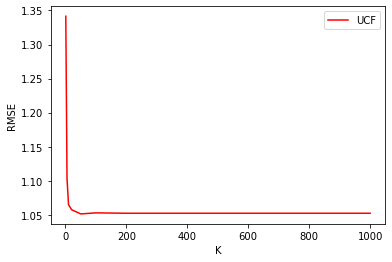

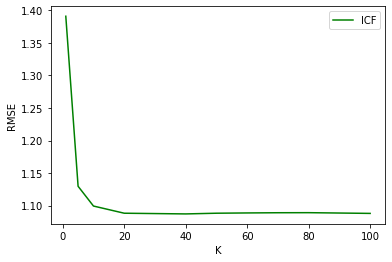

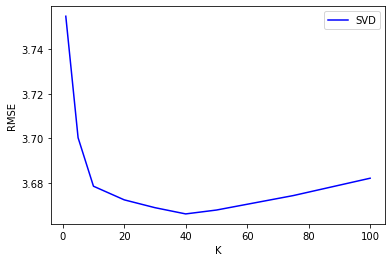

UCF  for k =  50  minimum RMSE is : 1.051345445157429
ICF  for k =  40  minimum RMSE is : 1.0873097610566602
SVD  for k =  40  minimum RMSE is : 3.6659885909617054
UA  for k =  k  minimum RMSE is : 1.0471870464722817
BA  for k =  k  minimum RMSE is : 1.089919681083236


In [17]:
combined_methods = []

kvalues = [1,5,10,20,50,100,200,500,1000]
combined_methods.append(["UCF",kvalues,ucfErrorist])

plt.plot(combined_methods[0][1],combined_methods[0][2], "-r", label=combined_methods[0][0]) 
    
plt.legend(loc="upper right")
plt.ylabel('RMSE')
plt.xlabel('K')
plt.show()

kvalues = [1,5,10,20,40,50,60,70,80,100]
combined_methods.append(["ICF",kvalues,icfErrorlist])

plt.plot(combined_methods[1][1],combined_methods[1][2], "-g", label=combined_methods[1][0]) 
    
plt.legend(loc="upper right")
plt.ylabel('RMSE')
plt.xlabel('K')
plt.show()

kvalues = [1,5,10,20,30,40,50,75,100]
combined_methods.append(["SVD",kvalues,svdErrorlist])

plt.plot(combined_methods[2][1],combined_methods[2][2], "-b", label=combined_methods[2][0]) 
    
plt.legend(loc="upper right")
plt.ylabel('RMSE')
plt.xlabel('K')
plt.show()



bestRMSEforMethods = []

for item in combined_methods:
    minError = item[2][0]
    indexForK = item[1][0]
    for i in range(len(item[1])):
        if minError > item[2][i]:
            minError = item[2][i]
            indexForK = item[1][i]
    label = item[0]
    bestRMSEforMethods.append([label,indexForK,minError])

bestRMSEforMethods.append(["UA","k",userAverageError])
bestRMSEforMethods.append(["BA","k",businessAverageError])
for item in bestRMSEforMethods:
    print(item[0]," for k = ",item[1]," minimum RMSE is :",item[2])
    


**Conclusion**

I notice that the UA method is the best of all and the SVD the worst. Also the results of UA are quite close to those issued by UCF. It should also be noted that in some test runs UCF produced lower RMSE than UA.

In SVD it can be seen from the graph that after some value in k that the error increases as k increases. While in the rest it remains almost constant.